In [8]:
%cd ComputerVisionProject/

[Errno 2] No such file or directory: 'ComputerVisionProject/'
/home/group.kurse/cviwo012/ComputerVisionProject


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [9]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from tqdm import tqdm
import os
import json

from CellDataset import CellDataset
from MoCoResNetBackbone import MoCoResNetBackbone
import matplotlib.pyplot as plt

In [ ]:
# ========== Configuration ==========
checkpoint_path = Path("/scratch/cv-course-group-5/models/training5/model_epoch50.pth")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

In [11]:
_json_path = Path('video_lists/train_test_split.json')

# Load the file
with open(_json_path, 'r') as f:
    _split_data = json.load(f)

# Access the train and test entries
train_list = _split_data.get("train", [])
test_list = _split_data.get("test", [])
val_list = _split_data.get("val", [])

In [12]:
# ========== Load model ==========
model = MoCoResNetBackbone()
model.to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# ========== Prepare dataset ==========
dataset = CellDataset(video_list=val_list[:3], mode='inference', label_mode='dead_alive_dividing', num_frames_labels=0)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

14378


In [ ]:
all_embeddings = []
all_labels = []
all_images = []

with torch.no_grad():
    for imgs, labels in tqdm(dataloader, desc="Extracting embeddings"):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.cpu().numpy()
        embeddings = model.encode_query(imgs)
        embeddings = embeddings.cpu().numpy()

        all_embeddings.append(embeddings)
        all_labels.append(labels)

        imgs_np = imgs.cpu().numpy()
        all_images.append(imgs_np)

Extracting embeddings:   0%|                        | 0/225 [00:00<?, ?it/s]

Extracting embeddings: 100%|██████████████| 225/225 [00:11<00:00, 18.95it/s]


In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

label_names = {0: "dead", 1: "alive", 2: "dividing"}

# Concatenate everything
images = np.concatenate(all_images, axis=0)
labels = np.concatenate(all_labels, axis=0)

selected_images = []
selected_labels = []

j = 0
for label in [0, 1, 2]:
    indices = np.where(labels == label)[0]
    selected_idx = indices[j:j+12] 
    selected_images.extend(images[selected_idx])
    selected_labels.extend([label] * 12)

# Denormalize images
def denormalize(img):
    img = img * std[:, None, None] + mean[:, None, None]  # denormalize
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))
    return img

In [20]:
# Plot
for i, img in enumerate(selected_images):
    label = selected_labels[i]
    title = f"{label}: {label_names[label]}"

    plt.figure(figsize=(2, 2))
    plt.imshow(denormalize(img))
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"plots/example_images/img_{i}_{label_names[label]}.png")
    plt.close()
    #plt.show()

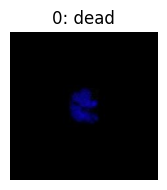

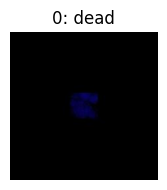

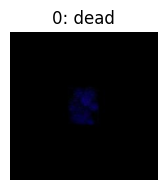

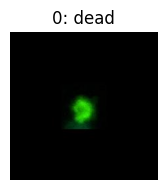

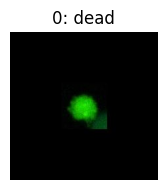

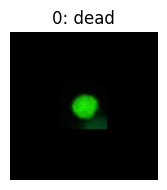

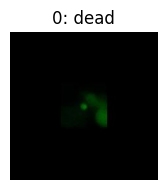

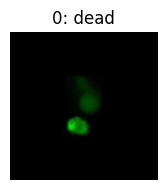

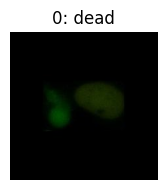

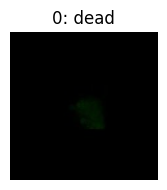

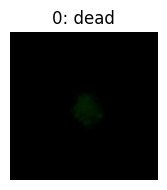

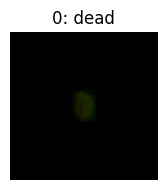

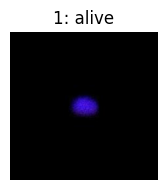

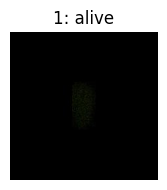

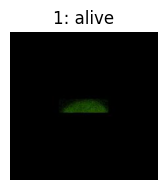

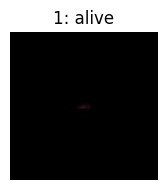

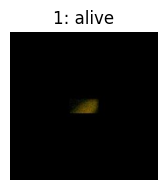

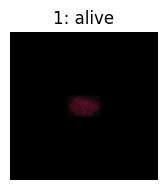

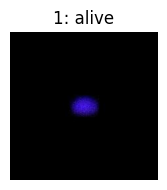

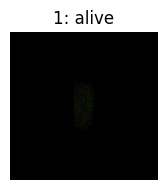

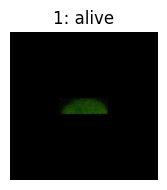

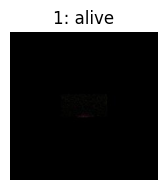

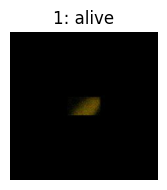

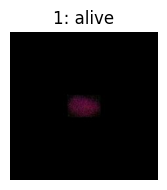

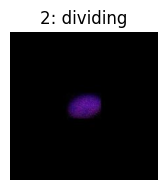

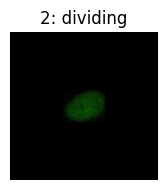

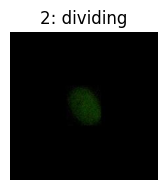

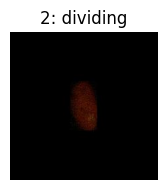

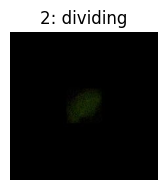

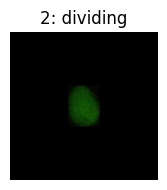

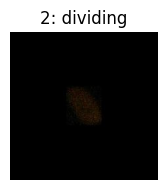

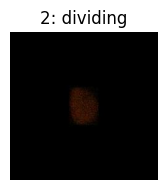

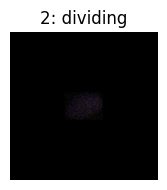

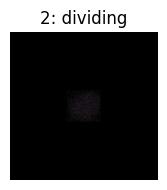

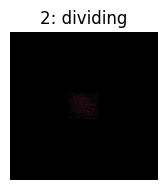

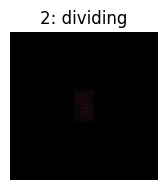

In [19]:
# Plot
for i, img in enumerate(selected_images):
    label = selected_labels[i]
    title = f"{label}: {label_names[label]}"

    plt.figure(figsize=(2, 2))
    plt.imshow(denormalize(img))
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig(f"plots/example_images/img_{i}_{label_names[label]}.png")
    plt.show()
    plt.close()